In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## SVM on GrayScale

In [11]:
def extract_features(video_id, base_path, lda):
    features = []
    folder_path = os.path.join(base_path, str(video_id))
    if os.path.exists(folder_path):
        for frame in os.listdir(folder_path):
            frame_path = os.path.join(folder_path, frame)
            img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (64, 64)) 
                features.append(img.flatten())
    
    if features:
        features = np.array(features)
        lda_features = lda.transform(features)
        lda_features = np.mean(lda_features, axis=0)
        return lda_features
    else:
        return np.zeros(lda.n_components)



In [6]:
data = pd.read_csv('data.csv')
base_path = 'data'

In [8]:
def train_lda(X, y, n_components=3):
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    return lda

all_features = []
all_labels = []
for _, row in data.iterrows():
    video_id = row['video_id']
    label = row['label_id']
    folder_path = os.path.join(base_path, str(video_id))
    if os.path.exists(folder_path):
        for frame in os.listdir(folder_path):
            frame_path = os.path.join(folder_path, frame)
            img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (64, 64))
                all_features.append(img.flatten())
                all_labels.append(label)

all_features = np.array(all_features)
all_labels = np.array(all_labels)


lda = train_lda(all_features, all_labels)


In [12]:
data['features'] = data['video_id'].apply(lambda x: extract_features(x, base_path, lda))

In [13]:
X = np.vstack(data['features'].values)
y = data['label_id'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
class LinearSVM(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(n_features, n_classes, bias=False)

    def forward(self, x):
        return self.fc(x)



In [23]:
def evaluate_accuracy(model, loader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [34]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y))
model = LinearSVM(n_features, n_classes)
model = model.cuda()

criterion = nn.MultiMarginLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_list = []
train_acc = []
val_acc = []

def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        train_accuracy = evaluate_accuracy(model, train_loader)
        val_accuracy = evaluate_accuracy(model, val_loader)
        loss_list.append(avg_train_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)


        print(f'Epoch {epoch}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

train(model, criterion, optimizer, train_loader, val_loader, num_epochs=1000)


Epoch 0, Loss: 0.8749, Train Accuracy: 13.56%, Validation Accuracy: 15.65%
Epoch 1, Loss: 0.8690, Train Accuracy: 14.31%, Validation Accuracy: 16.13%
Epoch 2, Loss: 0.8607, Train Accuracy: 15.06%, Validation Accuracy: 16.37%
Epoch 3, Loss: 0.8523, Train Accuracy: 15.72%, Validation Accuracy: 16.92%
Epoch 4, Loss: 0.8457, Train Accuracy: 16.03%, Validation Accuracy: 17.34%
Epoch 5, Loss: 0.8365, Train Accuracy: 16.37%, Validation Accuracy: 17.59%
Epoch 6, Loss: 0.8294, Train Accuracy: 16.84%, Validation Accuracy: 17.89%
Epoch 7, Loss: 0.8219, Train Accuracy: 17.40%, Validation Accuracy: 18.74%
Epoch 8, Loss: 0.8141, Train Accuracy: 17.97%, Validation Accuracy: 19.35%
Epoch 9, Loss: 0.8071, Train Accuracy: 18.43%, Validation Accuracy: 20.01%
Epoch 10, Loss: 0.7999, Train Accuracy: 18.98%, Validation Accuracy: 20.56%
Epoch 11, Loss: 0.7914, Train Accuracy: 19.26%, Validation Accuracy: 20.86%
Epoch 12, Loss: 0.7861, Train Accuracy: 19.87%, Validation Accuracy: 21.29%
Epoch 13, Loss: 0.7802

In [35]:
torch.save(model, 'SVM_model.pt')

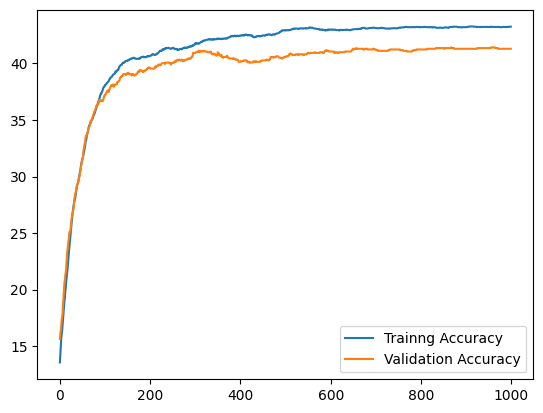

In [36]:
plt.plot(np.arange(0, 1000), train_acc, label='Trainng Accuracy')
plt.plot(np.arange(0, 1000), val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

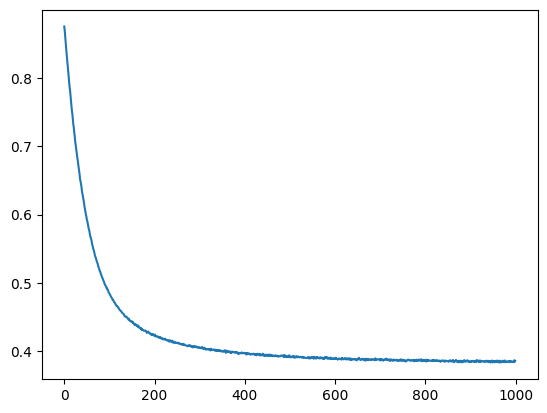

In [37]:
plt.plot(np.arange(0, 1000), loss_list)
plt.show()

In [44]:
def test_model(model, test_loader):
    model = model.cuda()
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in test_loader:
            inputs, labels = data[0], data[1]
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    return accuracy


test_accuracy = test_model(model, test_loader)

Accuracy of the model on the test set: 41.94%


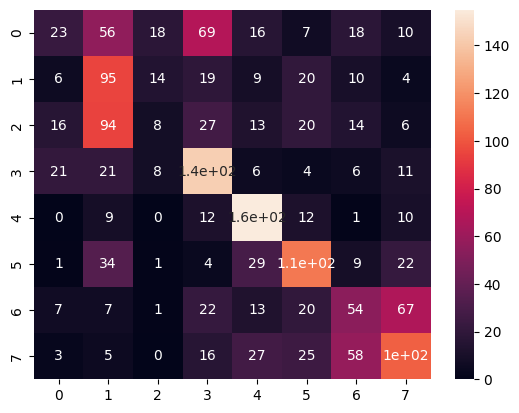

In [47]:
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)


sns.heatmap(cm, annot=True)
plt.show()